# Data Preprocessing

## Importing Data
---
Complete the following:
- Use the parameter 'usecols' to select all columns from the raw data that are needed
- Use the parameter 'parse_dates' to have Pandas automatically parse date info as it is brought in
- Use the paremeter 'index_col' to set the index to the datetime column if this is time series data
- Use the .query() function to import data that's conditional upon another columns values
- Anonymize or remove sensitive data
- Remove unneeded columns such as timestamps, counts, etc. that are guaranteed to have no relationship on the target

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns # Used for correlation heat map
from sklearn.datasets import make_classification
from skorch import NeuralNetClassifier, NeuralNetRegressor
from torch import nn
import torch.nn.functional as F


raw_data = pd.read_csv('./data/TrainingSet.csv')
if isinstance(raw_data, pd.DataFrame):
    print("Data successfully imported.")
else:
    print("Data failed to import.")


test_set = pd.read_csv('./data/TestSet.csv')
if isinstance(test_set, pd.DataFrame):
    print("Test data successfully imported.")
else:
    print("Test data failed to import.")
    
# Remove unneeded columns
del raw_data['timestamp']
del test_set['timestamp']

# Time series example
# hourly_weather_data = pd.read_csv('./data/raw_weather_data.csv', usecols=['DATE','REPORT_TYPE','HourlyDryBulbTemperature', 'HourlyPrecipitation'] , parse_dates=["DATE"], index_col="DATE").query("REPORT_TYPE == 'FM-15'")

print("Data Shape:",raw_data.shape) 
print("Test Shape:",test_set.shape)


C:\Users\Jonathan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (50,172,255,256,257,258,268,280,376) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data successfully imported.


C:\Users\Jonathan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (50,255,256,257,258,260,268) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Test data successfully imported.
Data Shape: (20000, 379)
Test Shape: (20000, 379)


## Separate Data into Training, Validation, Test, and Target Sets
---
##### It is very important that this step is done prior to data imputation, normalization, one hot encoding or other preprocessing steps.


In [84]:
from sklearn.model_selection import train_test_split

# Separate data into training, validation, and test sets
train_set, validation_set, train_targets, validation_targets = train_test_split(raw_data, raw_data['job_performance'], test_size=0.2)

# Set target and drop from training/test set data
del train_set['job_performance']
del validation_set['job_performance']
del test_set['job_performance']

print("Training Set Shape:",train_set.shape)
print("Validation Set Shape:",validation_set.shape)
print("Test Set Shape:",test_set.shape)
print(train_targets.head(5))
print(validation_targets.head(5))

Training Set Shape: (16000, 378)
Validation Set Shape: (4000, 378)
Test Set Shape: (20000, 378)
3590    3542.530232
9450    2570.573236
8920    2987.550084
8973    2678.691487
2355    3290.185764
Name: job_performance, dtype: float64
18236    2688.626247
17294    2833.726177
1052     3468.057196
18459    3444.561079
15105    3131.312678
Name: job_performance, dtype: float64


## Custom Pipeline Functions

In [85]:
import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import VarianceThreshold


class Print(BaseEstimator, TransformerMixin):    
    def __init__(self, message, return_shape=False, columns=False):
        self.message = message
        self.return_shape = return_shape
        self.columns = columns
    
    def transform(self, X):
        shape = ""
        if(self.return_shape):
            shape = X.shape
        if(self.columns):
            shape = X.shape[1]
        print(self.message, shape)
        
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class MissingValueRatioFilter(BaseEstimator, TransformerMixin):
    def __init__(self, ratio_missing):
        self.ratio_missing = ratio_missing
        self.selected_columns = []
        
    def transform(self, X):
        X = X[self.selected_columns]
        return X

    def fit(self, X, y=None, **fit_params):        
        # drop column if % of data missing is greater than this percentage
        temp = X.copy(deep=True)
        ratio = self.ratio_missing #0.1
        threshold = int(X.shape[0] * ratio)

        self.selected_columns = list(temp.dropna(thresh=len(temp)-threshold,axis=1).columns)
        
        return self

    
class ChangeDType(BaseEstimator, TransformerMixin):     
    def transform(self, X):
        X = X.astype(str)
        
        return X

    def fit(self, X, y=None, **fit_params):
        return self
    
class ConvertToDataFrame(BaseEstimator, TransformerMixin):
        
    def transform(self, X):
        X = pd.DataFrame(X.toarray())
        print("    Converted Matrix to DataFrame")

        return X

    def fit(self, X, y=None, **fit_params):
        return self

class ForceToNumerical(BaseEstimator, TransformerMixin):
    def transform(self, X):
        X['v71'] = pd.to_numeric(X['v71'], errors='coerce')
        
        return X

    def fit(self, X, y=None, **fit_params):
        return self
    
class HighCorrelationFilter(BaseEstimator,TransformerMixin):
    def __init__(self, correlation_decimal):
        self.selected_columns = []
        self.correlation_decimal = correlation_decimal
        
    def transform(self,X):
        print("      Selected Features:",len(self.selected_columns))
        X = X.iloc[:,self.selected_columns]
        
        return X
    
    def fit(self, X, y=None, **fit_params):
        test = X.iloc[:,0:10]
        corr = test.corr()
    
        columns = np.full((corr.shape[0],), True, dtype=bool)
        for i in range(corr.shape[0]):
            for j in range(i+1, corr.shape[0]):
                if corr.iloc[i,j] >= self.correlation_decimal:
                    if columns[j]:
                        columns[j] = False

        self.selected_columns = list(test.columns[columns])
        
        return self

class StartTimer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.start_time = datetime.datetime.now()
    
    def transform(self, X):
        return X

    def fit(self, X, y=None, **fit_params):
        return self
    
    
class OutputRunTime(BaseEstimator, TransformerMixin):
    def __init__(self, start_time):
        self.start_time = start_time
        
    def transform(self, X):
        return X

    def fit(self, X, y=None, **fit_params):
        end_time = datetime.datetime.now()
        print(">>>Fit Time(seconds):", (end_time - self.start_time).total_seconds())
        return self

## Master Pipeline

In [86]:
X = train_set.copy(deep=True)
V = validation_set.copy(deep=True)
T = test_set.copy(deep=True)

# Numerical transformations
numerical_missing_ratio = 0.5
variance_threshold = 0.01
numerical_colums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']  
numerical_features = list(X.select_dtypes(include=numerical_colums).columns)  
numerical_transformer = Pipeline(steps=[
    ('print1', Print(message="  Preprocessing:")),
    ('print2', Print(message="    Numerical: Missing Value Ratio Filter (>"+str(numerical_missing_ratio)+")")),
    ('print3', Print(message="      Starting Numerical Features: ",columns=True)),
    ('missing_value_ratio_filter', MissingValueRatioFilter(ratio_missing=numerical_missing_ratio)),
    ('print4', Print(message="      Remaining Numerical Features:",columns=True)),
    ('print5', Print(message="    Numerical: Imputation")),
    ('imputer', SimpleImputer(strategy='mean')),
    ('print6', Print(message="    Numerical: Normalization")),
    ('scaler', MinMaxScaler()),
    ('print7', Print(message="    Numerical: Low Variance Filter (>"+str(variance_threshold)+")")),
    ('print8', Print(message="      Starting Numerical Features: ",columns=True)),
    ('variance_threshold', VarianceThreshold(threshold=variance_threshold)),
    ('print9', Print(message="      Remaining Numerical Features:",columns=True))
    ])

# Categorical transformations
categorical_missing_ratio = 0.5
categorical_variance_threshold = 0.01
categorical_features = X.select_dtypes(['object']).columns
categorical_transformer = Pipeline(steps=[
    ('print0', Print(message="    Categorical: Missing Value Ratio Filter (>"+str(categorical_missing_ratio)+")")),
    ('print1', Print(message="      Starting Categorical Features: ",columns=True)),
#     ('missing_value_ratio_filter', MissingValueRatioFilter(ratio_missing=categorical_missing_ratio)),
    ('print2', Print(message="      Remaining Categorical Features:",columns=True)),
    ('print3', Print(message="    Categorical: Imputation")),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('print4', Print(message="    Categorical: Conversion of Ints to Strings")),
    ('change_dtype', ChangeDType()),
    ('print5', Print(message="    Categorical: One Hot Encoding")),
    ('print6', Print(message="      Starting Categorical Features:",columns=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('print7', Print(message="      Remaining Categorical Features:",columns=True)),
    ('print8', Print(message="    Categorical: Low Variance Filter (>"+str(categorical_variance_threshold)+")")),
    ('print9', Print(message="      Starting Categorical Features: ",columns=True)),
#     ('variance_threshold', VarianceThreshold(threshold=categorical_variance_threshold)),
    ('print10', Print(message="      Remaining Categorical Features:",columns=True))
    ])

# Combine numerical and categorical data back together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Master pipeline
high_correlation_filter_decimal = 0.9
master_pipeline = Pipeline([
    ('start_timer', StartTimer()),
    ('print1', Print(message="\nStarting Shape: " + str(X.shape))),
    ('print2', Print(message="  Forcing column 'v71' to numerical data.")),
    ('force_to_numerical', ForceToNumerical()),
    ('preprocessor', preprocessor),
    ('print3', Print(message="  Recombined Numerical & Categorical Shape: ",return_shape=True)),
    ('print4', Print(message="  Dimensionality Reduction: ")),
    ('convert_to_dataframe', ConvertToDataFrame()),
    ('print5', Print(message="    High Correlation Filter (> " + str(high_correlation_filter_decimal) + ")")),
    ('high_correlation_filter', HighCorrelationFilter(correlation_decimal=high_correlation_filter_decimal)),
    ('print6', Print(message="Final Shape:",return_shape=True)),
    ('output_run_time', OutputRunTime(start_time=master_pipeline.named_steps['start_timer'].start_time))
])

# Run numerical data only
  # X = pd.DataFrame(numerical_transformer.fit_transform(cleaned_train_set[numerical_features]))
  # X.head(10)


##### Run on train set
##### Last runtime = 7,094 seconds
train_set_processed = pd.DataFrame(master_pipeline.fit_transform(X))
validation_set_processed = pd.DataFrame(master_pipeline.transform(V))
test_set_processed = pd.DataFrame(master_pipeline.transform(T))



Starting Shape: (16000, 378) 
  Forcing column 'v71' to numerical data. 
  Preprocessing: 
    Numerical: Missing Value Ratio Filter (>0.5) 
      Starting Numerical Features:  84
      Remaining Numerical Features: 36
    Numerical: Imputation 
    Numerical: Normalization 
    Numerical: Low Variance Filter (>0.01) 
      Starting Numerical Features:  36
      Remaining Numerical Features: 30
    Categorical: Missing Value Ratio Filter (>0.5) 
      Starting Categorical Features:  294
      Remaining Categorical Features: 294
    Categorical: Imputation 
    Categorical: Conversion of Ints to Strings 
    Categorical: One Hot Encoding 
      Starting Categorical Features: 294
      Remaining Categorical Features: 2765
    Categorical: Low Variance Filter (>0.01) 
      Starting Categorical Features:  2765
      Remaining Categorical Features: 2765
New Shape:  (16000, 2795)
  Dimensionality Reduction:  
    Converted Matrix to DataFrame
    High Correlation Filter (> 0.9) 
      Sele

### Save Pipeline to File

In [87]:
from sklearn.externals import joblib

joblib.dump(master_pipeline, 'master_pipeline.joblib')

['master_pipeline.joblib']

### Load Pipeline File

In [89]:
pipeline = joblib.load('master_pipeline.joblib') 
test_set_processed = pipeline.transform(T)


Starting Shape: (16000, 378) 
  Forcing column 'v71' to numerical data. 
  Preprocessing: 
    Numerical: Missing Value Ratio Filter (>0.5) 
      Starting Numerical Features:  84
      Remaining Numerical Features: 36
    Numerical: Imputation 
    Numerical: Normalization 
    Numerical: Low Variance Filter (>0.01) 
      Starting Numerical Features:  36
      Remaining Numerical Features: 30
    Categorical: Missing Value Ratio Filter (>0.5) 
      Starting Categorical Features:  294
      Remaining Categorical Features: 294
    Categorical: Imputation 
    Categorical: Conversion of Ints to Strings 
    Categorical: One Hot Encoding 
      Starting Categorical Features: 294
      Remaining Categorical Features: 2765
    Categorical: Low Variance Filter (>0.01) 
      Starting Categorical Features:  2765
      Remaining Categorical Features: 2765
New Shape:  (20000, 2795)
  Dimensionality Reduction:  
    Converted Matrix to DataFrame
    High Correlation Filter (> 0.9) 
      Sele

## Dimensionality Reduction & Feature Selection
---
Link: https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
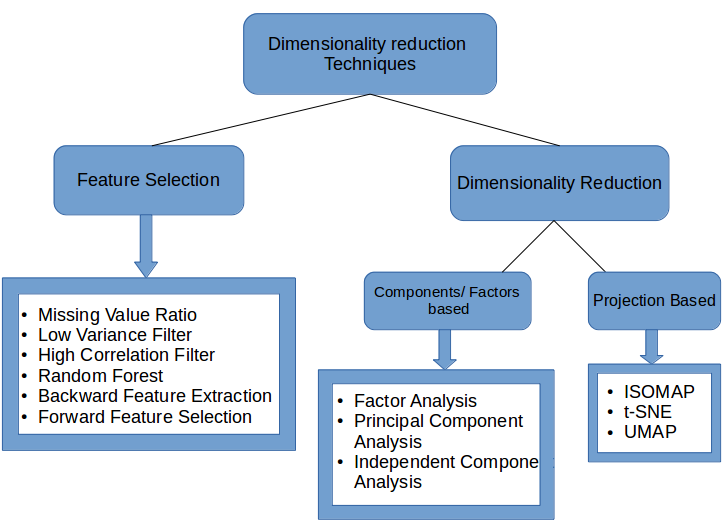
- <strong>Missing Value Ratio:</strong> If the dataset has too many missing values, we use this approach to reduce the number of variables. We can drop the variables having a large number of missing values in them
- <strong>Low Variance Filter:</strong> We apply this approach to identify and drop constant variables from the dataset. The target variable is not unduly affected by variables with low variance, and hence these variables can be safely dropped
- <strong>High Correlation Filter:</strong> A pair of variables having high correlation increases multicollinearity in the dataset. So, we can use this technique to find highly correlated features and drop them accordingly
- <strong>Random Forest:</strong> This is one of the most commonly used techniques which tells us the importance of each feature present in the dataset. We can find the importance of each feature and keep the top most features, resulting in dimensionality reduction
- <strong>Backward Feature Elimination & Forward Feature Selection:</strong> These techniques take a lot of computational time and are thus generally used only on smaller datasets.
- <strong>Factor Analysis:</strong> This technique is best suited for situations where we have highly correlated set of variables. It divides the variables based on their correlation into different groups, and represents each group with a factor
- <strong>Principal Component Analysis:</strong> This is one of the most widely used techniques for dealing with linear data. It divides the data into a set of components which try to explain as much variance as possible
- <strong>Independent Component Analysis:</strong> We can use ICA to transform the data into independent components which describe the data using less number of components
- <strong>ISOMAP:</strong> We use this technique when the data is strongly non-linear
- <strong>t-SNE:</strong> This technique also works well when the data is strongly non-linear. It works extremely well for visualizations as well
- <strong>UMAP:</strong> This technique works well for high dimensional data. Its run-time is shorter as compared to t-SNE

### Backward Feature Elimination

The p-value in a regression study is used to determine the statistical significance of a feature. Removal of different features from the dataset will have differing effects on the p-values of how other features effect the dataset. We can remove features systematically and measure the restulting p-values of the remaining features in each case. These measured p-values can be used to decide whether to keep a feature or not.

This is what we are doing in the code block below:
- First we calculate the p-values for all current columns.
- Then we locate the column with the highest p-value that's greater than set significance level (SL) and drop that column.
- Then we recalculate the p-values of all remaining columns and continue to drop the least significant column until all of our columns fall under the significance level threshold.

In [1]:
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        # Finds new regression p_values after each column is dropped
        regressor_OLS = sm.OLS(Y, x).fit()
        # Determines the highest p_value remaining and then finds that column and drops it
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            # Drops columns from end towards beginning
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    # Drops column matching the highest p_value
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)

#     print(regressor_OLS.summary())
    return x, columns, regressor_OLS.summary()

SL = 0.05
data_modeled, stat_significant_columns, report = backwardElimination(processed_train_set.values, train_targets.values, SL, selected_columns)
processed_train_set = processed_train_set[stat_significant_columns]
print("Starting features:",len(selected_columns))
print("Remaining statistically significant features:",processed_train_set.shape[1])
print(report)

### Export Preprocessed Data to CSV

In [19]:
X.to_csv(r'./data/1614_Preprocessed_TrainingSet.csv', index=False)
V.to_csv(r'./data/1614_Preprocessed_ValidationSet.csv', index=False)
y.to_csv(r'./data/1614_Preprocessed_TestSet.csv', index=False)
# train_targets.to_csv(r'./data/Preprocessed_TrainingTargets.csv', header=['job_performance'], index=False)
# test_targets.to_csv(r'./data/Preprocessed_TestingTargets.csv', header=['job_performance'], index=False)

## Filled NAs with mean
#1815 (7,094 seconds) was with 0.7 missing ratio filter and .01 variance filter on numerical, no filters on categorical, high correlation filter of 0.9
#1616 (4,155 seconds) was with 0.5 missing ratio filter and .01 variance filter on numerical, no filters on categorical, high correlation filter of 0.7